# Broker Manager
In this file we test the basiscs of receiving and sending messages through MQTT connectios

### Old codes

Subscriber

In [ ]:
# -*- coding: utf-8 -*-
"""
----MQTT subscribe code----

Runs on Mosquitto broker
InfluxDB database not included
Ip address available from CMD command: ipconfig all
"""

#!/usr/bin/env python3

# import required packages

import paho.mqtt.client as mqtt
import json
import pandas as pd
#import datetime
import time
from time import sleep
import numpy as np

# defining topics to subscribe

def on_connect(client, userdata, flags, rc):
  print("Connected with result code "+str(rc))
  client.subscribe(topic="activity")

# manipulation of subscribed message data
def on_message(client, userdata, msg):
    # define global variables
    #print(msg.payload) 
    print(str(msg.payload.decode("utf-8")))     # to print the message string
    json_value = json.loads(msg.payload.decode())  #converting message string to python dictionary
    print("time",json_value['time'])   # calling individual data in the json dictionary
    print(json_value)



client = mqtt.Client()
client.connect("127.0.0.1",1883,60,) # verify the IP address before connect

client.on_connect = on_connect
client.on_message = on_message


client.loop_start()
condition = True

while condition:        # the system stays connected as long as the condition is "True"
    sleep(1)
    
client.loop_stop()    
client.disconnect()

Manager

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  5 16:37:07 2019

@author: giova
"""

#!/usr/bin/env python3

import paho.mqtt.client as mqtt
import json
import pandas as pd
#import datetime
import time
from time import sleep
import numpy as np
from influx import InfluxDB

# connect to influx
db = InfluxDB('http://192.168.0.50:8086',precision='ms')
NOME_DATABASE = "lego"

# This is the Subscriber

activity_log = []
states_log = []

count = 0
start_time = 0
th = 0

b3 = 1
b4 = 1
b5 = 0

def on_connect(client, userdata, flags, rc):
  print("Connected with result code "+str(rc))
  client.subscribe("topic/activity")
  client.subscribe("topic/states")
  client.subscribe("topic/buffers")
  client.subscribe("topic/operators")
  

def on_message(client, userdata, msg):
    
    global start_time
    global count
    global th
    global b3
    global b4
    global b5
    global th
    
    if msg.payload.decode() == "start" or msg.payload.decode() == "stop":
        pass
    
    elif msg.topic == "topic/activity":
        
        # print(msg.payload) 
        # print(msg.payload.decode())
        # print(json.loads(msg.payload))
        # print(msg.payload.decode())
        
        json_value = json.loads(msg.payload.decode())  #conversione da stringa a dizionario python
          
        # print("activity",json_value['activity'])
        # print("id",json_value['id'])
        # print("ts",json_value['ts'])
        # print("tag",json_value['tag'])    
        #  json_value['time'] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") #change timestamp!
        json_value['ts'] = time.time() #change timestamp!
        activity_log.append(json_value)
        #    influx write senza timestamp
        db.write(NOME_DATABASE,'eventlog', fields={"id":json_value['id'],"type":json_value['tag']}, tags={"activity":json_value['activity']})
    
#        evaluate THROUGHPUT
        if json_value['tag'] =='f' and json_value['activity'] == 1:
            
            try:
                thput = 1/(time.time() - start_time) 
                db.write(NOME_DATABASE,'throughput', fields={"th": thput}, tags={"activity":6})
                start_time = time.time()
            except: 
                pass
            
#            if len(th)<5:
#                th.append(time.time())
#            
#            if len(th)>=5:
#                th = th[1:] +[time.time()] 
#                thput = len(th)/(th[-1] - th[0])
#            
##                thput = count / (time.time() - start_time)
#    #            print("THROUGHPUT: "+str(th))
#                db.write(NOME_DATABASE,'throughput', fields={"th": thput}, tags={"activity":6})

    elif msg.topic == "topic/states":
        
        json_value = json.loads(msg.payload.decode())  #conversione da stringa a dizionario python

#        print("activity",json_value['activity'])
#        print("state",json_value['state'])
        json_value['ts'] = time.time() #change timestamp!
        
        states_log.append(json_value)

#        influx write        
        db.write(NOME_DATABASE,'machine_state', fields={"activity":json_value['activity'], "state":json_value['state']})
    
    
    elif msg.topic == "topic/operators":
        
#        print('message received')
        
        json_value = json.loads(msg.payload.decode())  #conversione da stringa a dizionario python
#        print("BUFFER MESSAGE:"+ str(json_value))
#        MAPPING VALUES FOR DASHBOARD

        if json_value['operator'] == True:
            db.write(NOME_DATABASE,'operators', fields={"pos": json_value['station'] })
    
    
    elif msg.topic == "topic/buffers":
        
        json_value = json.loads(msg.payload.decode())  #conversione da stringa a dizionario python
#        print("BUFFER MESSAGE:"+ str(json_value))
#        MAPPING VALUES FOR DASHBOARD

        
        if json_value['station'] == 3:
        
            if json_value['buffer'] == 'L':
                b3 = 1
                
            if json_value['buffer'] == 'M':
                b3 = 2
                
            if json_value['buffer'] == 'H':
                b3 = 3
                
        if json_value['station'] == 4:
            
            if json_value['buffer'] == 'L':
                b4 = 1
                
            if json_value['buffer'] == 'M':
                b4 = 2
                
            if json_value['buffer'] == 'H':
                b4 = 3
        
        if json_value['station'] == 5:
            
            if json_value['buffer'] == 'NF':
                b5 = 0
                
            if json_value['buffer'] == 'F':
                b5 = 4
                       
#        print("3: " + json_value['3'] + "4: "+str(json_value['4']))
#        print("3: " + str(b3)+ "4: "+str(b4))

#        states_log.append(json_value)

#        influx write        
        db.write(NOME_DATABASE,'buffers', fields={"b3": b3, "b4": b4, "b5": b5})
    
    if msg.payload.decode() == "disc":
        
        print("Disconnecting...")
        client.disconnect()
        
    elif msg.payload.decode() == "start":
        print("STARTED!")
        start_time  = time.time()
    
client = mqtt.Client()
client.connect("192.168.0.50",1883,60)

client.on_connect = on_connect
client.on_message = on_message

th = []

client.loop_start()


condition = True

while condition:
    sleep(1)
    
client.loop_stop()    
client.disconnect()


#DEBUGGING
#json_value = {"time": 123}
#json_value['time'] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#activity_log.append(json_value)

df = pd.DataFrame(activity_log)       # pass to pandas df

for a in df.activity.unique().tolist():

    # processing times
    pt = np.array([])
    # tutti gli id che hanno fatto questa attivita
    for i in df.id.unique().tolist():
#        print(i)
        try:
            pt = np.append(pt, (df[(df.activity == a) & (df.id == i) & (df.tag == 'f')].ts.values  - df[(df.activity == a) & (df.id == i) & (df.tag == 's')].ts.values).tolist()  )
        except:
            continue    
    
    np.savetxt('processing'+str(a)+'.txt', pt, delimiter='\n', fmt='%f')
    
    #arrival times:
    # tutti gli id che hanno fatto questa attivita
    #for i in df.id.unique().tolist():
    
    at = np.diff(df[ (df.activity == a) & (df.tag == 'f')].ts)
    np.savetxt('arrivals'+str(a)+'.txt', at, delimiter='\n', fmt='%f')


df = df.sort_values(by ='ts')
df.to_csv(r'log.csv')


# PARTE SU EV3
#activity_log.append({"activity" : 6, "id" : 1, "ts" : 6, "tag" : "f" })
#
#data_out = json.dumps(a, indent = 4)
#client.publish("topic/test", data_out)

### Simply testing of connections

Payload should be in the format:

```json
{
    "time" : 10,
    "workpieces" : 50,
    "free" : "no"
}

```

functions

In [8]:
import paho.mqtt.client as mqtt
from time import sleep
import json

def on_connect(client, userdata, flags, rc):
  print("Connected with result code "+str(rc))
  client.subscribe(topic="activity")

def on_message(client, userdata, msg):
    print(str(msg.payload.decode("utf-8")))     # to print the message string
    json_value = json.loads(msg.payload.decode())  #converting message string to python dictionary
    print("time",json_value['time'])   # calling individual data in the json dictionary
    print(json_value)
    

connection

In [9]:
client = mqtt.Client()
#client.connect("127.0.0.1",1883,60,) # verify the IP address before connect

client.connect("10.169.81.165",1883,60,)

client.on_connect = on_connect
client.on_message = on_message

Loop of connection

In [10]:
client.loop_start()
condition = True

while condition:        # the system stays connected as long as the condition is "True"
    sleep(1)
    
client.loop_stop()    
client.disconnect()

Connected with result code 0
{
    "time" : 11,
    "workpieces" : 50,
    "free" : "no"
}
time 11
{'time': 11, 'workpieces': 50, 'free': 'no'}


KeyboardInterrupt: 

# Test with the Broker Manager

In [17]:
#--- Import modules from the library
from dtwinpylib.dtwinpy.Digital_Twin import Digital_Twin
from dtwinpylib.dtwinpy.broker_manager import Broker_Manager

#--- Reload modules
import importlib
import dtwinpylib
importlib.reload(dtwinpylib.dtwinpy.Digital_Twin)
importlib.reload(dtwinpylib.dtwinpy.broker_manager) 

<module 'dtwinpylib.dtwinpy.broker_manager' from 'c:\\Users\\pedro\\Github Repositories\\Digital_Twin\\Digital Twin\\dtwinpylib\\dtwinpy\\broker_manager.py'>

Normal testing

In [10]:
my_pc_ip_address = "10.169.114.208"
database_path = "databases/broker_test.db"
broker_manager = Broker_Manager(ip_address=my_pc_ip_address, real_database_path= database_path)


In [11]:
broker_manager.run()

.
.
----- Connected with 10.169.114.208 Successfully -----
Subscribed Topics:
|-- 'trace'
|-- 'part_id'
|-- 'RCT-server'
07 March 2023 21:07:54 | Topic: trace | Payload Received: {'machine_id': '1', 'part_id': '12', 'queue_id': '1', 'status': 'Started'}
---- Communication with 10.169.114.208 killed manually----


#### Publishing

In [28]:
broker_manager.publishing(1,12,3)

[BROKER] 07 March 2023 19:20:11 | Topic: RCT-server | Payload Published: {"machine_id": 1, "part_id": 12, "queue_id": 3}


In [15]:
import re

string = 'Part 12 of 1 of 10 ...'
number = re.findall(r'\d+', string)[0]
print(number)  # Output: 2241


12


## Test with Digital Twin Service

In [26]:
#--- Import modules from the library
from dtwinpylib.dtwinpy.Digital_Twin import Digital_Twin
from dtwinpylib.dtwinpy.broker_manager import Broker_Manager
from dtwinpylib.dtwinpy.interfaceDB import Database

#--- Reload modules
import importlib
import dtwinpylib
importlib.reload(dtwinpylib.dtwinpy.Digital_Twin)
importlib.reload(dtwinpylib.dtwinpy.broker_manager)

<module 'dtwinpylib.dtwinpy.broker_manager' from 'c:\\Users\\pedro\\Github Repositories\\Digital_Twin\\Digital Twin\\dtwinpylib\\dtwinpy\\broker_manager.py'>

In [5]:
db = Database("databases/name/real_database.db", "real_log")

OperationalError: unable to open database file

====== Paths Created ======
---- Path 1 ----
Conveyor towards Queue 2
Conveyor towards Queue 4
---- Path 2 ----
Conveyor towards Queue 2
Conveyor towards Queue 5
---- Path 3 ----
Conveyor towards Queue 3
Conveyor towards Queue 4
---- Path 4 ----
Conveyor towards Queue 3
Conveyor towards Queue 5
====================================== Simulation AS IS for Part 1 ======================================
### ============ Simulation Started ============ ###
Time: 0 - [Machine 1] got Part 1 from Queue 1 (capacity= 0)
Time: 0 - [Machine 2] got Part 2 from Queue 2 (capacity= 0)
Time: 3368 - [Conveyor towards Queue 4] GOT Part 2
Time: 3369 - [Conveyor towards Queue 4] PUT Part 2 in the Queue 4
Time: 3370 - [Machine 4] got Part 2 from Queue 4 (capacity= 0)
Time: 5592 - [Conveyor towards Queue 2] GOT Part 1
Time: 5593 - [Conveyor towards Queue 2] PUT Part 1 in the Queue 2
Time: 5594 - [Machine 2] got Part 1 from Queue 2 (capacity= 0)
Time: 8143 - [Conveyor towards Queue 7] GOT Part 2
Time: 8144 - [

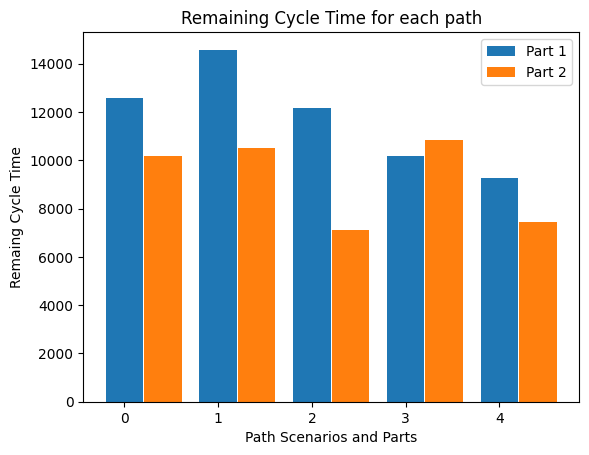

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


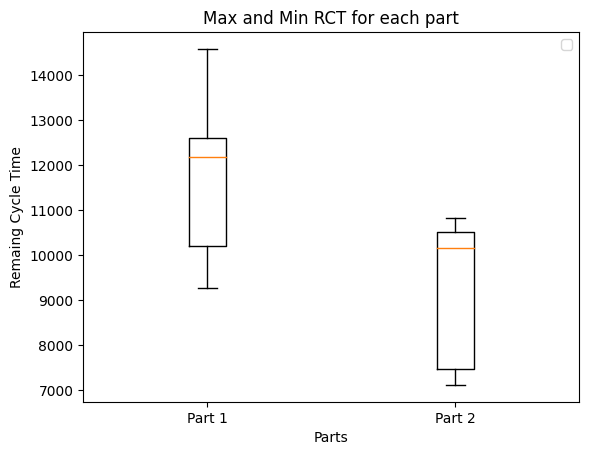

____________________________________________


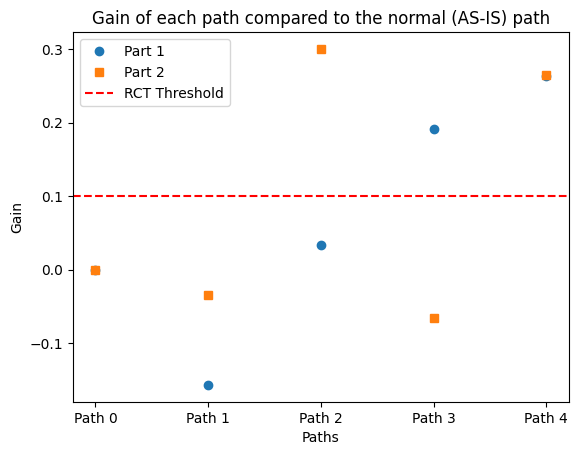


!!!!!!!!! Optimized Path Found for Part 1 !!!!!!!!!
> Best Path: Path 4
> Gain: 26.401 %
> Path:
|- Conveyor towards Queue 3
|- Conveyor towards Queue 5

!!!!!!!!! Optimized Path Found for Part 2 !!!!!!!!!
> Best Path: Path 2
> Gain: 30.036 %
> Path:
|- Conveyor towards Queue 2
|- Conveyor towards Queue 5
Trying to publish: Part 1
[BROKER] 10 March 19:04:01 | Topic: RCT_server | Payload Published: {"machine_id": 1, "part_id": "a", "queue_id": 3}
sleeping...
waking up!
Trying to publish: Part 2
[BROKER] 10 March 19:04:02 | Topic: RCT_server | Payload Published: {"machine_id": 2, "part_id": "b", "queue_id": 5}
sleeping...
waking up!


In [27]:
my_pc_ip_address = "10.169.81.165"

mydt = Digital_Twin(name= "5s_deterministic_complex", targeted_part_id= 1)
mydt.initiate_broker(ip_address= my_pc_ip_address)
mydt.run_RCT_services(verbose= True)

In [1]:
#--- Import Broker Manager class
from dtwinpylib.dtwinpy.broker_manager import Broker_Manager

#--- Setting of the broker
factory_ip_address = "192.168.0.50"
polimi_ip_address = "10.169.114.208"
home_ip_address = "192.168.1.223"

database_path = "databases/RFID_test.db"

#--- Create the Broker Manager
broker_manager = Broker_Manager(ip_address=factory_ip_address, real_database_path= database_path)

#--- Run Communication
broker_manager.run()


.
.
----- Connected with 192.168.0.50 Successfully -----
Subscribed Topics:
|-- 'trace'
|-- 'part_id'
|-- 'RCT_server'


Exception in thread Thread-3 (_thread_main):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2800.0_x64__qbz5n2kfra8p0\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\pedro\.virtualenvs\dtwinpyenv-JC8N3fR1\lib\site-packages\paho\mqtt\client.py", line 3591, in _thread_main
    self.loop_forever(retry_first_connection=True)
  File "c:\Users\pedro\.virtualenvs\dtwinpyenv-JC8N3fR1\lib\site-packages\paho\mqtt\client.py", line 1756, in loop_forever
    rc = self._loop(timeout)
  File "c:\Users\pedro\.virtualenvs\dtwinpyenv-JC8N3fR1\lib\site-packages\paho\mqtt\client.py", line 1164, in _loop
    rc = self.loop_read()
  File "c:\Users\pedro\.virtualenvs\dtwinpyenv-JC8N3fR1\lib\site-packages\paho\mqtt\client.py",

08 March 2023 19:20:39 | Topic: part_id | Payload Received: 2
---- Communication with 192.168.0.50 killed manually----


In [15]:
import sqlite3

# Create a connection to the database
conn = sqlite3.connect('example.db')
c = conn.cursor()

# Function to add a UID and counter to the table
def add_UID_counter(table_name, uid, counter):
    # Check if UID already exists in table
    c.execute(f"SELECT UID FROM {table_name} WHERE UID = ?", (uid,))
    result = c.fetchone()
    if result is None:
        # UID does not exist in table, so insert new row
        c.execute(f"INSERT INTO {table_name} (UID, PID) VALUES (?, ?)", (uid, counter))
    else:
        # UID already exists in table, so update existing row
        c.execute(f"UPDATE {table_name} SET PID = ? WHERE UID = ?", (counter, uid))
    conn.commit()

# Function to retrieve PID for a given counter
def get_PID(table_name, counter):
    c.execute(f"SELECT UID FROM {table_name} WHERE PID = ?", (counter,))
    result = c.fetchone()
    if result is None:
        return None
    else:
        return result[0]


with sqlite3.connect('example.db') as db:
    db.execute(f"""
    CREATE TABLE IF NOT EXISTS ID (
        line_id INTEGER PRIMARY KEY,
        timestamp INTEGER,
        UID TEXT,
        PID TEXT
    )
    """)

    db.commit()


# Close the database connection when done
conn.close()


In [16]:
# Create a connection to the database
conn = sqlite3.connect('example.db')
c = conn.cursor()

add_UID_counter("ID", "uid1", "3")

print(get_PID("ID", 3))


# Close the database connection when done
conn.close()

uid1
